# Notebook to Analyze the Efficacy of Generative Models for Anomaly Detection

In this notebook we will look to use different generative models on graphs to learn distributions over normal graphs and hopefully detect some anomalies. We specifically start our experimentation looking at the GraphRNN framework implemented by the SNAP group

In [2]:
# Fun some setup for the project
# Silence annoying pytorch deprecated warnings
import warnings
warnings.filterwarnings("ignore")

from train import *
%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# All necessary arguments are defined in args.py
#args = Args()
#os.environ['CUDA_VISIBLE_DEVICES'] = str(args.cuda)
#print('CUDA', args.cuda)
print ('CUDA Available:', torch.cuda.is_available())

CUDA Available: True


In [3]:
# Define a useful function for getting the dataset to test/analyze
def get_graph_data(dataset, isModelDataset=False):
    """
        Given a dataset name, loads in the graphs of that dataset.
        Creates a specific argument object for that dataset to allow
        for different datasets to be created.
        
        return: If isModelDataset: returns args, train, val, test split
                else: returgn args, data
    """
    args_data = Args()
    args_data.change_dataset(dataset)
    
    # Load the graph data - Consider using presaved datasets! with graph load list
    graphs = create_graphs.create(args_data)
    graphs_len = len(graphs)
    random.seed(123)
    shuffle(graphs)

    # Display some graph stats
    graph_node_avg = 0
    for graph in graphs:
        graph_node_avg += graph.number_of_nodes()
    graph_node_avg /= graphs_len
    print('Average num nodes', graph_node_avg)

    args_data.max_num_node = max([graphs[i].number_of_nodes() for i in range(graphs_len)])
    max_num_edge = max([graphs[i].number_of_edges() for i in range(graphs_len)])
    min_num_edge = min([graphs[i].number_of_edges() for i in range(graphs_len)])

    # show graphs statistics
    print('total graph num: {}'.format(graphs_len))
    print('max number node: {}'.format(args_data.max_num_node))
    print('max/min number edge: {}; {}'.format(max_num_edge,min_num_edge))
    print('max previous node: {}'.format(args_data.max_prev_node))
    
    if isModelDataset:
        # split datasets
        graphs_len = len(graphs)
        graphs_test = graphs[int(0.8 * graphs_len):]
        graphs_train = graphs[0:int(0.8*graphs_len)]
        graphs_validate = graphs[0:int(0.2*graphs_len)]
        return args_data, graphs_train, graphs_validate, graphs_test
    
    return args_data, graphs
          

In [4]:
# Generate the model datasets (i.e. the dataset used to train
# the model - normal data)
args_enzy, train_enzy, val_enzy, test_enzy = get_graph_data("enzymes_small", isModelDataset=True)
# Save the max_previous node to allow for model 
# compatability on future datasets
max_prev_node = args_enzy.max_prev_node

Loading graph dataset: ENZYMES
Loaded
Average num nodes 15.81651376146789
total graph num: 109
max number node: 20
max/min number edge: 49; 17
max previous node: 15


In [5]:
# Initialize the dataset and dataloader for analyzing the nlls. 
# Note that we use batch_size = 1 because we want the nll for each
# data point not an average across a batch.
# We should also consider using Graph_sequence_Sampler_pytorch_nll.
# This sampler expands the size of the dataset by for each graph 
# creating many different bfs permutations. The idea behind this sampler
# is to test the models permutation invariance. 

train_dataset = Graph_sequence_sampler_pytorch_rand(train_enzy,max_prev_node=args_enzy.max_prev_node,max_num_node=args_enzy.max_num_node)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, num_workers=args_enzy.num_workers)

test_dataset = Graph_sequence_sampler_pytorch_rand(test_enzy, max_prev_node=args_enzy.max_prev_node,max_num_node=args_enzy.max_num_node)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, num_workers=args_enzy.num_workers)



In [6]:
# Model initialization
# Using GraphRNN

rnn = GRU_plain(input_size=args_enzy.max_prev_node, embedding_size=args_enzy.embedding_size_rnn,
                        hidden_size=args_enzy.hidden_size_rnn, num_layers=args_enzy.num_layers, has_input=True,
                        has_output=True, output_size=args_enzy.hidden_size_rnn_output).to(device)
output = GRU_plain(input_size=1, embedding_size=args_enzy.embedding_size_rnn_output,
                        hidden_size=args_enzy.hidden_size_rnn_output, num_layers=args_enzy.num_layers, has_input=True,
                        has_output=True, output_size=1).to(device)

In [7]:
# This function encapsulates the process of getting the loglikelihoods
# of the data
def calc_nll(args, data_loader, rnn, output, max_iter=100, load_epoch=3000, train_dataset=None):
    """
        For now the max_iter is not used. However, the idea in the future
        is to do max_iter loops of calculating the nlls of the data. Since
        the model is permutation dependent, namely we use a random bfs ordering
        for each graph when training/testing, we should do many iterations to
        test the robustness of the model to permutation. This could also be
        addressed using nll data_loader. 
    """
    # Set the epoch we are loading from
    args.load_epoch = load_epoch
    if train_dataset:
        fname = args.note + '_' + train_dataset + '_' + str(args.num_layers) + '_' + str(args.hidden_size_rnn) + '_'
        fname_rnn = args.model_save_path + fname + 'lstm_' + str(args.load_epoch) + '.dat'
        fname_out = args.model_save_path + fname + 'output_' + str(args.load_epoch) + '.dat'
    else:
        fname_rnn = args.model_save_path + args.fname + 'lstm_' + str(args.load_epoch) + '.dat'
        fname_out = args.model_save_path + args.fname + 'output_' + str(args.load_epoch) + '.dat'
    
    print (fname_rnn)
    rnn.load_state_dict(torch.load(fname_rnn))
    output.load_state_dict(torch.load(fname_out))

    epoch = args.load_epoch
    print('model loaded!, epoch: {}'.format(args.load_epoch))

    # Calculate nll over dataset max_iter times,
    # to test robustness to permutations of the bfs
    # ordered adjacency matrix for the same graphs.
    nlls = []
    for i in range(max_iter):
        nll = rnn_data_nll(args, rnn, output, data_loader)
        # Logging info
        # May want to also include std statistics
        if (i + 1) % 10 == 0:
            print ("Iteration:", i + 1)
            print ("Average Nll:", np.mean(nll))
            
        nlls.extend(nll)
        
    return nlls

./model_save/GraphRNN_RNN_enzymes_small_4_64_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 10
Average Nll: 25.89893265428214
Iteration: 20
Average Nll: 25.995508511861164
Iteration: 30
Average Nll: 25.53121985512218
Iteration: 40
Average Nll: 26.43345241985102
Iteration: 50
Average Nll: 24.609570503234863
Iteration: 60
Average Nll: 25.610458330176343
Iteration: 70
Average Nll: 24.09825776089197
Iteration: 80
Average Nll: 26.885327163783984
Iteration: 90
Average Nll: 24.112449317142882
Iteration: 100
Average Nll: 25.809319304323743


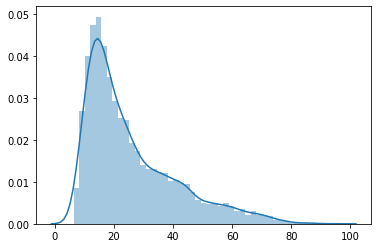

In [8]:
# Let's do some analysis on the training data
nlls = calc_nll(args_enzy, train_loader, rnn, output)
plt.figure()
sns.distplot(nlls, kde=True)
#plt.xlim([0, 55])

./model_save/GraphRNN_RNN_enzymes_small_4_64_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 10
Average Nll: 39.13575961373069
Iteration: 20
Average Nll: 44.725196838378906
Iteration: 30
Average Nll: 45.10948879068548
Iteration: 40
Average Nll: 43.44435388391668
Iteration: 50
Average Nll: 45.53799347444014
Iteration: 60
Average Nll: 45.756103385578506
Iteration: 70
Average Nll: 40.453648047013715
Iteration: 80
Average Nll: 41.18992983211171
Iteration: 90
Average Nll: 41.7457332611084
Iteration: 100
Average Nll: 40.228785341436215


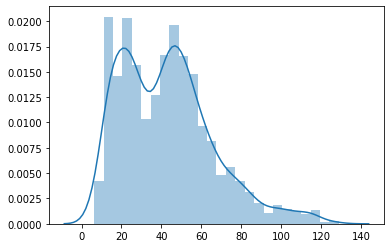

In [12]:
# Analysis of the test data set nlls.
nlls = calc_nll(args_enzy, test_loader, rnn, output)
plt.figure()
sns.distplot(nlls, kde=True)

In [18]:
# Now let's try using a different dataset on the same GraphRNN
# trained on the enzyemes small dataset. By plotting the distribution
# over the nlls of this test set from a different family, hopefully
# we can see the success of the generative model
args_ladder, graphs_ladder = get_graph_data("ladder_small", isModelDataset=False)

# Create dataset and dataloader object for the out of distribution ladder dataset
# Note that instead of passing in args.max_prev_node, we pass in the saved max_prev_node
# saved specifically for the enzyme dataset - hack to allow for GraphRNN to work on any dataset
ladder_dataset = Graph_sequence_sampler_pytorch_rand(graphs_ladder,max_prev_node=max_prev_node,max_num_node=args_ladder.max_num_node)
ladder_loader = torch.utils.data.DataLoader(ladder_dataset, batch_size=1, num_workers=args_ladder.num_workers)

Average num nodes 12.0
total graph num: 9
max number node: 20
max/min number edge: 28; 4
max previous node: 10


./model_save/GraphRNN_RNN_enzymes_small_4_64_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 10
Average Nll: 76.49963972303603
Iteration: 20
Average Nll: 79.44567320081923
Iteration: 30
Average Nll: 79.43467670016818
Iteration: 40
Average Nll: 84.88898764716254
Iteration: 50
Average Nll: 74.74217224121094
Iteration: 60
Average Nll: 74.61162990993924
Iteration: 70
Average Nll: 69.80481041802301
Iteration: 80
Average Nll: 70.16738234625922
Iteration: 90
Average Nll: 75.98890431722005
Iteration: 100
Average Nll: 81.37251154581706


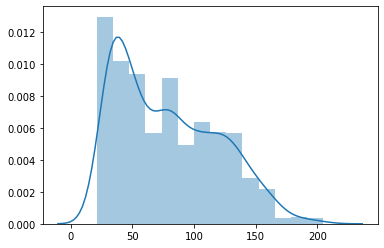

In [15]:
# Let's see how the nlls of the ladder graphs compare to 
# the trained on enzymes
nlls = calc_nll(args_ladder, ladder_loader, rnn, output, train_dataset="enzymes_small")
plt.figure()
sns.distplot(nlls, kde=True)

In [19]:
# Now let's try using a different dataset on the same GraphRNN
# trained on the enzyemes small dataset. By plotting the distribution
# over the nlls of this test set from a different family, hopefully
# we can see the success of the generative model
args_caveman, graphs_caveman = get_graph_data("caveman_small", isModelDataset=False)

# Create dataset and dataloader object for the out of distribution ladder dataset
# Note that instead of passing in args.max_prev_node, we pass in the saved max_prev_node
# saved specifically for the enzyme dataset - hack to allow for GraphRNN to work on any dataset
caveman_dataset = Graph_sequence_sampler_pytorch_rand(graphs_caveman,max_prev_node=max_prev_node,max_num_node=args_caveman.max_num_node)
caveman_loader = torch.utils.data.DataLoader(caveman_dataset, batch_size=1, num_workers=args_caveman.num_workers)

Average num nodes 15.99
total graph num: 100
max number node: 20
max/min number edge: 83; 19
max previous node: 20


./model_save/GraphRNN_RNN_enzymes_small_4_64_lstm_3000.dat
model loaded!, epoch: 3000
Iteration: 10
Average Nll: 113.14893434524537
Iteration: 20
Average Nll: 112.75899436950684
Iteration: 30
Average Nll: 113.1734980392456
Iteration: 40
Average Nll: 113.36665554046631
Iteration: 50
Average Nll: 113.74079584121704
Iteration: 60
Average Nll: 113.96001651763916
Iteration: 70
Average Nll: 112.96768104553223
Iteration: 80
Average Nll: 116.68466108322144
Iteration: 90
Average Nll: 117.34124488830567
Iteration: 100
Average Nll: 114.21455732345581


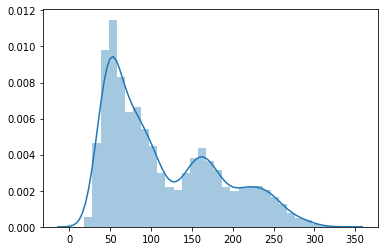

In [20]:
# Let's see how the nlls of the caveman graphs compare to 
# the trained on enzymes
nlls = calc_nll(args_caveman, caveman_loader, rnn, output, train_dataset="enzymes_small")
plt.figure()
sns.distplot(nlls, kde=True)